In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

In [4]:
api = wandb.Api()

entity = "justin_yang-university-of-california-berkeley"
project = "cs182-project-GPT-opt"
sweep_id = "5pllqyjx" # phase1-safetyfactor

sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/jasontrinh/.netrc
wandb: Currently logged in as: jasontrinh (jasontrinh-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
for run in sweep.runs:
    print(f"Run ID: {run.id}")
    # print("---------- CONFIG ----------")
    # print("Safety Factor:", run.config["optimizer_params"]["args"]["polar_safety"])
    # for key in run.config.keys():
    #     print(key + ":", run.config[key])
    # print(run.summary["svd/update_layer0_v/condition_number"])
    # print("---------- SUMMARY ----------")
    # for key in run.summary.keys():
    #     print(key + ":", run.summary[key])
    # print("---------- HISTORY ----------")
    # for step in run.scan_history():
    #     # print(step["svd/update_layer0_stacked/condition_number"])
    #     for key in step.keys():
    #         print(key)
    #     break
    # break

Run ID: ud9tmam7
Run ID: pgavu9tw
Run ID: oso9lime
Run ID: ly4ms4uh
Run ID: zh36wbcn
Run ID: exhbqbum


In [6]:
def get_data(sweep_id, optimizer_param_name, optimizer_param_vals, update, layer, matrix, metric):

    if update:
        update = "update_"
    else:
        update = ""

    entity = "justin_yang-university-of-california-berkeley"
    project = "cs182-project-GPT-opt"

    api = wandb.Api()
    sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

    data = {val: [] for val in optimizer_param_vals}

    for run in sweep.runs:
        run_id = run.id
        run_param = run.config["optimizer_params"]["args"][optimizer_param_name]

        data[run_param].append(np.array([step[f"svd/{update}layer{layer}_{matrix}/{metric}"] for step in run.scan_history()]))

    return data

In [7]:
def plot_data(sweep_id, param_name, param_id, param_vals, \
              update, layer, matrix, metric, start, end, \
              use_ci=False, log_scale=False, plot_med=True, save_plot=False):

    print("Getting Data...")
    data = get_data(sweep_id, param_id, param_vals, update, layer, matrix, metric)

    if update:
        update = "update_"
    else:
        update = ""

    df = {}
    for val in [1, 1.01]:
    
        arrays = data[val]
        valid_mask = arrays[0] != None
        steps = np.where(valid_mask)[0]
        valid_arrays = [x[valid_mask] for x in arrays]
        valid_arrays = np.asarray(valid_arrays, dtype=float)

        if use_ci:
            med_vec = np.mean(np.stack(valid_arrays), axis=0)
            std_vec = np.std(np.stack(valid_arrays), axis=0)
            N = np.stack(valid_arrays).shape[0]
            sem_vec = std_vec / np.sqrt(N)
            min_vec = med_vec - 1.96 * sem_vec
            max_vec = med_vec + 1.96 * sem_vec
        else:
            med_vec = np.median(np.stack(valid_arrays), axis=0)
            min_vec = np.min(np.stack(valid_arrays), axis=0)
            max_vec = np.max(np.stack(valid_arrays), axis=0)
    
        med_vec = np.asarray(med_vec, dtype=float)
        min_vec = np.asarray(min_vec, dtype=float)
        max_vec = np.asarray(max_vec, dtype=float)
    
        df[f"med_vec_{val}"] = med_vec
        df[f"min_vec_{val}"] = min_vec
        df[f"max_vec_{val}"] = max_vec

        if log_scale:
            df[f"med_vec_{val}"] = np.log(med_vec)
            df[f"min_vec_{val}"] = np.log(min_vec)
            df[f"max_vec_{val}"] = np.log(max_vec)
    
    df["Step"] = steps
    df = pd.DataFrame(df)
    df_iloc = df.iloc[start:end+1]

    print("Plotting Data...")
    sns.set_style("whitegrid")
    for val in [1, 1.01]:
        if plot_med:
            sns.lineplot(data=df_iloc, x="Step", y=f"med_vec_{val}")
        steps = df_iloc["Step"]
        min_vec = df_iloc[f"min_vec_{val}"]
        max_vec = df_iloc[f"max_vec_{val}"]
        plt.fill_between(steps, min_vec, max_vec, alpha=0.3, label=f"{val}");

    plt.title(f"{update.replace("_", "").title()} Layer {layer} {matrix.title()} - {metric.replace("_", " ").title()}")
    plt.xlabel("Step")
    if log_scale:
        plt.ylabel(f"{metric.replace("_", " ").title()} (Log Scale)")
    else:
        plt.ylabel(f"{metric.replace("_", " ").title()}")
    plt.legend(title = param_name)
    
    if save_plot:
        print("Plot Saved.")
        plt.savefig(f"./plots/{param_id}/{metric}/{update}layer{layer}_{matrix}_{metric}_{param_id}.jpg")
    
    plt.show();

Getting Data...
Plotting Data...
Plot Saved.


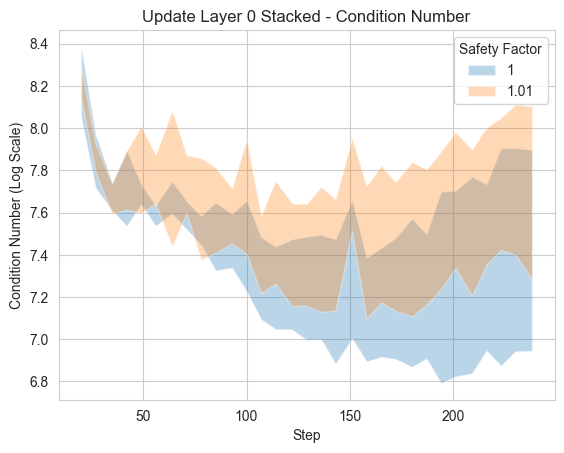

In [ ]:
sweep_id = "5pllqyjx"
param_name = "Safety Factor"
param_id = "polar_safety"
param_vals = [1, 1.01]
update = True
layer = 0
matrix = "stacked"
metric = "condition_number"
start = 2
end = 32
use_ci = True
log_scale = True
plot_med = False
save_plot = True

plot_data(sweep_id, param_name, param_id, param_vals, update, layer, matrix, metric, start, end, use_ci, log_scale, plot_med, save_plot)

In [27]:
ENTITY = "justin_yang-university-of-california-berkeley"
PROJECT = "cs182-project-GPT-opt"

# Map high-level optimizer categories to sweep IDs or run IDs.
ATTN_CATEGORIES = {
    "AdamW": ["pxrm9xt8", "hkw05gba", "eifb7cyl"],
    "Muon-NS-All": ["qmzevjll", "lh2tzeh1"],
    "Muon-NS-VOFFN": ["88vr9lps"],
    "Muon-PE-All": ["emzbw2qc"],
    "Muon-PE-VOFFN": ["67g7mm51"],
}

# Nicer titles for figure headers
ATTN_CATEGORY_TITLES = {
    "AdamW": "AdamW",
    "Muon-NS-All": "Muon Newton-Schulz (all matrices)",
    "Muon-NS-VOFFN": "Muon Newton-Schulz (V, O, FFN)",
    "Muon-PE-All": "Muon PolarExpress (all matrices)",
    "Muon-PE-VOFFN": "Muon PolarExpress (V, O, FFN)",
}

# Fixed y-axis range for all attention entropy plots
DEFAULT_YLIM = (0.0, 6.0)

# Use epoch fraction on x-axis instead of raw step
USE_EPOCH_X = True
EPOCH_MAX = 0.3  # runs are 0.3 epochs


def _collect_runs_for_ids(ids, entity=ENTITY, project=PROJECT):
    """Given a list of sweep IDs and/or run IDs, return a flat list of runs."""
    api = wandb.Api()
    runs = []
    for _id in ids:
        # Try treating as a sweep ID first
        try:
            sweep = api.sweep(f"{entity}/{project}/{_id}")
            runs.extend(list(sweep.runs))
            continue
        except Exception:
            pass
        # Fallback: single run ID
        try:
            run = api.run(f"{entity}/{project}/{_id}")
            runs.append(run)
        except Exception as e:
            print(f"Warning: could not load sweep or run '{_id}': {e}")
    return runs


def get_attn_entropy_for_ids(ids, layer, entity=ENTITY, project=PROJECT):
    """Aggregate attn/layer{layer}/entropy/mean across runs.

    Returns a DataFrame with columns: lr, step, mean, std, sem, n.
    """
    metric_key = f"attn/layer{layer}/entropy/mean"
    runs = _collect_runs_for_ids(ids, entity=entity, project=project)
    records = []

    for run in runs:
        # Try nested sweep config, then flat key
        lr = None
        try:
            lr = run.config["optimizer_params"]["args"]["lr"]
        except Exception:
            lr = run.config.get("optimizer_params.args.lr", None)
        if lr is None:
            continue

        for row in run.scan_history():
            if metric_key not in row:
                continue
            val = row[metric_key]
            step = row.get("_step", None)
            if step is None or val is None:
                continue
            records.append(
                {
                    "lr": float(lr),
                    "step": int(step),
                    "value": float(val),
                    "run_id": run.id,
                }
            )

    if not records:
        return pd.DataFrame(columns=["lr", "step", "mean", "std", "sem", "n"])

    df = pd.DataFrame(records)
    grouped = (
        df.groupby(["lr", "step"])["value"]
        .agg(["mean", "std", "count"])
        .reset_index()
        .rename(columns={"count": "n"})
    )
    grouped["sem"] = grouped["std"] / np.sqrt(grouped["n"].clip(lower=1))
    grouped = grouped.sort_values(["lr", "step"])
    return grouped


def plot_attn_entropy_category(
    category_name,
    ids,
    layer,
    ax=None,
    ylim=DEFAULT_YLIM,
    add_legend=True,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
):
    """Plot mean line + SEM band for a category (set of sweeps/runs) for one layer."""
    df = get_attn_entropy_for_ids(ids, layer)

    # For AdamW, drop very large learning rates to focus on the main range
    if category_name == "AdamW" and not df.empty:
        df = df[df["lr"] <= 0.0024 + 1e-12]

    if df.empty:
        print(f"No data found for {category_name}, layer {layer}")
        return

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))

    sns.set_style("whitegrid")

    # Normalize steps so that the earliest diagnostic log maps to epoch 0
    min_step = df["step"].min() if not df.empty else 0
    max_step = df["step"].max() if not df.empty else 0
    span = max(max_step - min_step, 1)

    for lr, sub in df.groupby("lr"):
        sub = sub.sort_values("step")
        steps = sub["step"].values.astype(float)
        mean_vals = sub["mean"].values
        sem_vals = sub["sem"].fillna(0.0).values

        if use_epoch_x:
            x_vals = (steps - min_step) / span * (epoch_max if epoch_max is not None else 1.0)
        else:
            x_vals = steps

        ax.plot(x_vals, mean_vals, label=f"{lr:g}")
        ax.fill_between(x_vals, mean_vals - sem_vals, mean_vals + sem_vals, alpha=0.25)

    title_base = ATTN_CATEGORY_TITLES.get(category_name, category_name)
    ax.set_title(f"Layer {layer} Attention Entropy for {title_base}", pad=14)
    ax.set_ylabel("Mean Entropy")
    if ylim is not None:
        ax.set_ylim(*ylim)

    # X-axis labeling
    if use_epoch_x:
        ax.set_xlabel("Epoch")
        if epoch_max is not None:
            ax.set_xlim(0.0, epoch_max)
    else:
        ax.set_xlabel("Step")
        ax.set_xlim(left=0.0)

    # Ensure y-axis tick labels are visible on all subplots
    ax.tick_params(axis="y", labelleft=True)

    if add_legend:
        ax.legend(title="Learning Rate", fontsize=8)

    return ax


def plot_layers_for_category(
    category_name,
    layers=(0, 5, 11),
    categories=ATTN_CATEGORIES,
    ylim=DEFAULT_YLIM,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
):
    """For a single category, make one figure with subplots (3 in a row by default)."""
    ids = categories[category_name]
    n_layers = len(layers)
    fig, axes = plt.subplots(1, n_layers, figsize=(5 * n_layers, 4), sharey=True)
    if n_layers == 1:
        axes = [axes]

    # First axis gets a legend so we can harvest handles/labels
    for i, (ax, layer) in enumerate(zip(axes, layers)):
        add_legend = (i == 0)
        plot_attn_entropy_category(
            category_name,
            ids,
            layer,
            ax=ax,
            ylim=ylim,
            add_legend=add_legend,
            use_epoch_x=use_epoch_x,
            epoch_max=epoch_max,
        )

    # Build a single shared legend from the first axis, then remove per-axis legend
    handles, labels = axes[0].get_legend_handles_labels()
    if axes[0].get_legend() is not None:
        axes[0].get_legend().remove()

    fig.legend(
        handles,
        labels,
        title="Learning Rate",
        loc="upper center",
        bbox_to_anchor=(0.5, 1.08),
        ncol=min(4, len(labels)),
        fontsize=8,
    )
    fig.suptitle(ATTN_CATEGORY_TITLES.get(category_name, category_name), y=1.16)
    fig.tight_layout(rect=(0, 0, 1, 0.93))
    plt.show()

    return fig, axes


def plot_all_layers(
    layers=(0, 5, 11),
    categories=ATTN_CATEGORIES,
    ylim=DEFAULT_YLIM,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
):
    """For each category, produce one figure with |layers| subplots (side by side)."""
    for name in categories.keys():
        plot_layers_for_category(
            name,
            layers=layers,
            categories=categories,
            ylim=ylim,
            use_epoch_x=use_epoch_x,
            epoch_max=epoch_max,
        )

In [100]:
# Variant-based plots for sweeps vqkcitxv (Muon variants) and ov703ihc (AdamW)

VARIANT_SWEEP_IDS = ["vqkcitxv", "ov703ihc"]

# Map raw muon_variant strings to concise display names
VARIANT_TITLE_MAP = {
    "pe_all": "Muon PE (all matrices)",
    "ns_all": "Muon NS (all matrices)",
    "pe_voffn": "Muon PE (V, O, FFN)",
    "ns_voffn": "Muon NS (V, O, FFN)",
    "pe_mod_all": "Muon PE-mod (all matrices)",
    "adamw": "AdamW",
}

# Canonical display-order for variants so colors stay fixed even if we filter
CANONICAL_VARIANTS = [
    "AdamW",
    "Muon NS (V, O, FFN)",
    "Muon NS (all matrices)",
    "Muon PE (V, O, FFN)",
    "Muon PE (all matrices)",
    "Muon PE-mod (all matrices)",
]


def _collect_variant_runs(sweep_ids=VARIANT_SWEEP_IDS, entity=ENTITY, project=PROJECT):
    api = wandb.Api()
    runs = []
    for sid in sweep_ids:
        try:
            sweep = api.sweep(f"{entity}/{project}/{sid}")
            runs.extend(list(sweep.runs))
        except Exception as e:
            print(f"Warning: could not load sweep '{sid}': {e}")
    return runs


def _get_variant_label(cfg):
    """Infer optimizer variant label from run config.

    - Prefer nested optimizer_params.args.muon_variant.
    - Fall back to flattened key optimizer_params.args.muon_variant.
    - Otherwise, treat as AdamW.
    """
    raw_variant = None

    # Nested form
    try:
        raw_variant = cfg["optimizer_params"]["args"].get("muon_variant")
    except Exception:
        pass

    # Flattened form
    if raw_variant is None:
        raw_variant = cfg.get("optimizer_params.args.muon_variant")

    if raw_variant is None:
        raw_variant = "adamw"

    return VARIANT_TITLE_MAP.get(raw_variant, raw_variant)


def get_loss_by_variant(metric_key, sweep_ids=VARIANT_SWEEP_IDS, entity=ENTITY, project=PROJECT):
    """Aggregate a scalar metric (e.g. train/loss) grouped by (variant, step).

    - metric_key: e.g. "train/loss" or "val/loss".
    - Uses `_step` if present; otherwise falls back to `epoch` or row index.
    """
    runs = _collect_variant_runs(sweep_ids=sweep_ids, entity=entity, project=project)
    records = []

    for run in runs:
        cfg = run.config
        variant = _get_variant_label(cfg)

        for i, row in enumerate(run.scan_history()):
            if metric_key not in row:
                continue
            val = row[metric_key]
            # Prefer W&B internal step; fall back to logged epoch or index
            step = row.get("_step")
            if step is None:
                step = row.get("epoch")
            if step is None:
                step = i
            if val is None:
                continue
            records.append(
                {
                    "variant": variant,
                    "step": float(step),
                    "value": float(val),
                    "run_id": run.id,
                }
            )

    if not records:
        print(f"{metric_key}: no records found in sweeps {sweep_ids}")
        return pd.DataFrame(columns=["variant", "step", "mean", "std", "sem", "n"])

    df = pd.DataFrame(records)
    grouped = (
        df.groupby(["variant", "step"])["value"]
        .agg(["mean", "std", "count"])
        .reset_index()
        .rename(columns={"count": "n"})
    )
    grouped["sem"] = grouped["std"] / np.sqrt(grouped["n"].clip(lower=1))
    grouped = grouped.sort_values(["variant", "step"])

    print(f"{metric_key}: found variants {sorted(grouped['variant'].unique())}")
    return grouped


def plot_all_variants_from_sweeps(
    sweep_ids=VARIANT_SWEEP_IDS,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
    epoch_window=None,
    include_adamw=True,
):
    """Plot train/loss and val/loss vs epoch with one line per optimizer variant.

    Left subplot: train/loss; Right subplot: val/loss.
    Legend: optimizer variant.

    Behavior:
    - If `epoch_window` is None: plot the full run in the simple "normal" way
      (one pass, line + SEM band, no interpolation, no custom y-limits).
    - If `epoch_window` is provided and `use_epoch_x` is True: use two-pass
      logic (full curve for context + highlighted window segment) and
      interpolate values at the window boundaries so both the line and SEM
      reach the axis edges.
    - If `include_adamw` is False, drop the AdamW curve(s) entirely.
    """
    # Aggregate metrics
    train_df = get_loss_by_variant("train/loss", sweep_ids=sweep_ids)
    val_df = get_loss_by_variant("val/loss", sweep_ids=sweep_ids)

    # Optional filtering of AdamW
    if not include_adamw:
        if not train_df.empty:
            train_df = train_df[train_df["variant"] != "AdamW"]
        if not val_df.empty:
            val_df = val_df[val_df["variant"] != "AdamW"]

    if train_df.empty and val_df.empty:
        print("No loss data found for the specified sweeps after filtering.")
        return

    # Set of all variants appearing in either metric
    variants = set()
    if not train_df.empty:
        variants.update(train_df["variant"].unique())
    if not val_df.empty:
        variants.update(val_df["variant"].unique())
    variants = [v for v in CANONICAL_VARIANTS if v in variants]

    if not variants:
        print("No variants to plot after filtering.")
        return

    # Fixed color map so variants have consistent colors across subplots
    palette = sns.color_palette(n_colors=len(CANONICAL_VARIANTS))
    color_map = {name: palette[i] for i, name in enumerate(CANONICAL_VARIANTS)}

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
    ax_train, ax_val = axes

    # --------- Case 1: full-run view (no window) ---------
    if epoch_window is None or not use_epoch_x:

        def _plot_metric(df, ax, ylabel):
            if df.empty:
                ax.set_visible(False)
                return

            sns.set_style("whitegrid")

            min_step = df["step"].min() if not df.empty else 0.0
            max_step = df["step"].max() if not df.empty else 0.0
            span = max(max_step - min_step, 1e-8)

            for variant in variants:
                sub = df[df["variant"] == variant]
                if sub.empty:
                    continue
                sub = sub.sort_values("step")
                steps = sub["step"].values.astype(float)
                mean_vals = sub["mean"].values
                sem_vals = sub["sem"].fillna(0.0).values

                if use_epoch_x:
                    x_vals = (steps - min_step) / span * (
                        epoch_max if epoch_max is not None else 1.0
                    )
                else:
                    x_vals = steps

                color = color_map.get(variant)

                ax.plot(x_vals, mean_vals, color=color, alpha=1.0, label=variant)
                ax.fill_between(
                    x_vals,
                    mean_vals - sem_vals,
                    mean_vals + sem_vals,
                    alpha=0.2,
                    color=color,
                )

            if use_epoch_x:
                ax.set_xlabel("Epoch")
                if epoch_max is not None:
                    ax.set_xlim(0.0, epoch_max)
            else:
                ax.set_xlabel("Step")
                ax.set_xlim(left=0.0)

            ax.set_ylabel(ylabel)
            ax.tick_params(axis="y", labelleft=True)

    # --------- Case 2: zoomed view with window ---------
    else:

        emin, emax = epoch_window

        def _plot_metric(df, ax, ylabel):
            if df.empty:
                ax.set_visible(False)
                return

            sns.set_style("whitegrid")

            # Compute epoch coordinate for all points once
            min_step = df["step"].min() if not df.empty else 0.0
            max_step = df["step"].max() if not df.empty else 0.0
            span = max(max_step - min_step, 1e-8)

            df_local = df.copy()
            df_local["epoch"] = (df_local["step"] - min_step) / span * (
                epoch_max if epoch_max is not None else 1.0
            )

            zoom_ymin, zoom_ymax = None, None

            for variant in variants:
                sub = df_local[df_local["variant"] == variant]
                if sub.empty:
                    continue
                sub = sub.sort_values("step")
                x_vals = sub["epoch"].values
                mean_vals = sub["mean"].values
                sem_vals = sub["sem"].fillna(0.0).values

                color = color_map.get(variant)

                # Full curve (will be clipped by xlim)
                ax.plot(x_vals, mean_vals, color=color, alpha=1.0)

                # Points strictly inside the window
                mask = (x_vals >= emin) & (x_vals <= emax)
                x_zoom = x_vals[mask]
                mean_zoom = mean_vals[mask]
                sem_zoom = sem_vals[mask]

                # Interpolate boundary points at emin and emax (if crossed)
                boundary_x = []
                boundary_mean = []
                boundary_sem = []
                if x_vals.size >= 2:
                    for b in (emin, emax):
                        j = np.searchsorted(x_vals, b)
                        if 0 < j < x_vals.size:
                            x0, x1 = x_vals[j - 1], x_vals[j]
                            if x1 == x0:
                                continue
                            t = (b - x0) / (x1 - x0)
                            m = mean_vals[j - 1] + t * (mean_vals[j] - mean_vals[j - 1])
                            s = sem_vals[j - 1] + t * (sem_vals[j] - sem_vals[j - 1])
                            boundary_x.append(b)
                            boundary_mean.append(m)
                            boundary_sem.append(s)

                if boundary_x:
                    x_ext = np.concatenate([x_zoom, np.array(boundary_x, dtype=float)])
                    mean_ext = np.concatenate([mean_zoom, np.array(boundary_mean, dtype=float)])
                    sem_ext = np.concatenate([sem_zoom, np.array(boundary_sem, dtype=float)])
                    order = np.argsort(x_ext)
                    x_zoom = x_ext[order]
                    mean_zoom = mean_ext[order]
                    sem_zoom = sem_ext[order]

                if x_zoom.size == 0:
                    continue

                # Highlight zoom segment + SEM, including boundary-interpolated points
                ax.plot(x_zoom, mean_zoom, color=color, alpha=1.0, label=variant)
                ax.fill_between(x_zoom, mean_zoom - sem_zoom, mean_zoom + sem_zoom, alpha=0.2, color=color)

                cur_min = float((mean_zoom - sem_zoom).min())
                cur_max = float((mean_zoom + sem_zoom).max())
                zoom_ymin = cur_min if zoom_ymin is None else min(zoom_ymin, cur_min)
                zoom_ymax = cur_max if zoom_ymax is None else max(zoom_ymax, cur_max)

            ax.set_xlabel("Epoch")
            ax.set_xlim(emin, emax)

            if zoom_ymin is not None and zoom_ymax is not None:
                pad = max(0.05 * (zoom_ymax - zoom_ymin), 0.02)
                ax.set_ylim(zoom_ymin - pad, zoom_ymax + pad)

            ax.set_ylabel(ylabel)
            ax.tick_params(axis="y", labelleft=True)

    # Call the appropriate plotting helper
    _plot_metric(train_df, ax_train, "Train Loss")
    _plot_metric(val_df, ax_val, "Val Loss")

    # Shared legend
    handles, labels = ax_train.get_legend_handles_labels()
    if ax_train.get_legend() is not None:
        ax_train.get_legend().remove()

    fig.legend(
        handles,
        labels,
        title="Optimizer Variant",
        loc="upper center",
        bbox_to_anchor=(0.5, 1.08),
        ncol=min(3, len(labels)),
        fontsize=8,
    )

    if epoch_window is None:
        title_suffix = "(full run)"
    else:
        title_suffix = f"(Epoch {epoch_window[0]:.2f}–{epoch_window[1]:.2f})"

    fig.suptitle(f"Train and Validation Loss by Optimizer Variant {title_suffix}", y=1.16)
    fig.tight_layout(rect=(0, 0, 1, 0.93))
    plt.show()

    return fig, axes

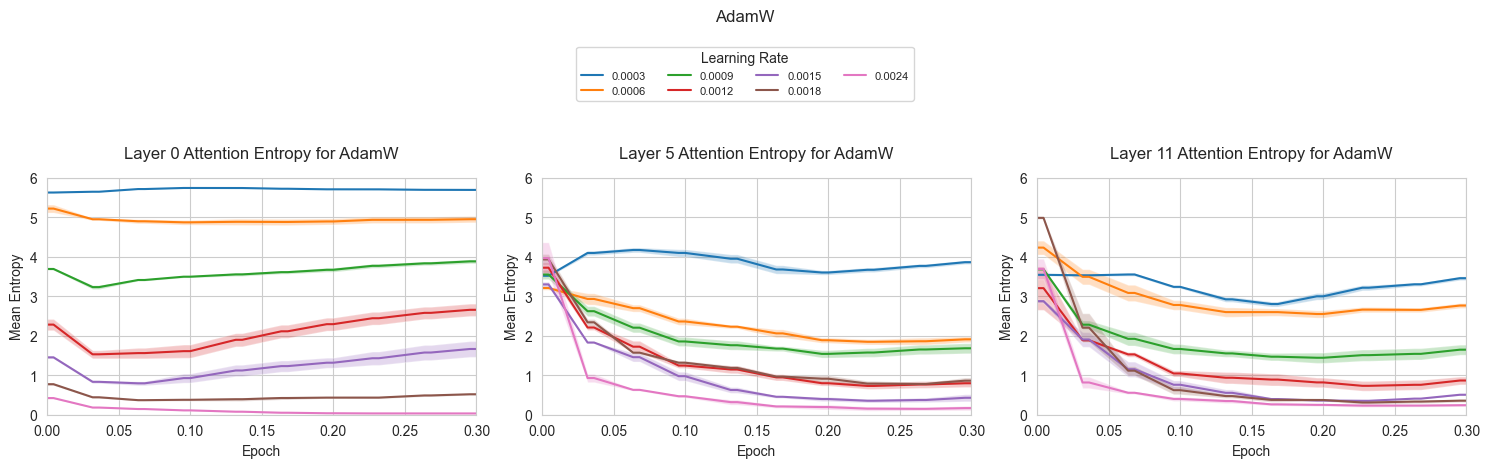

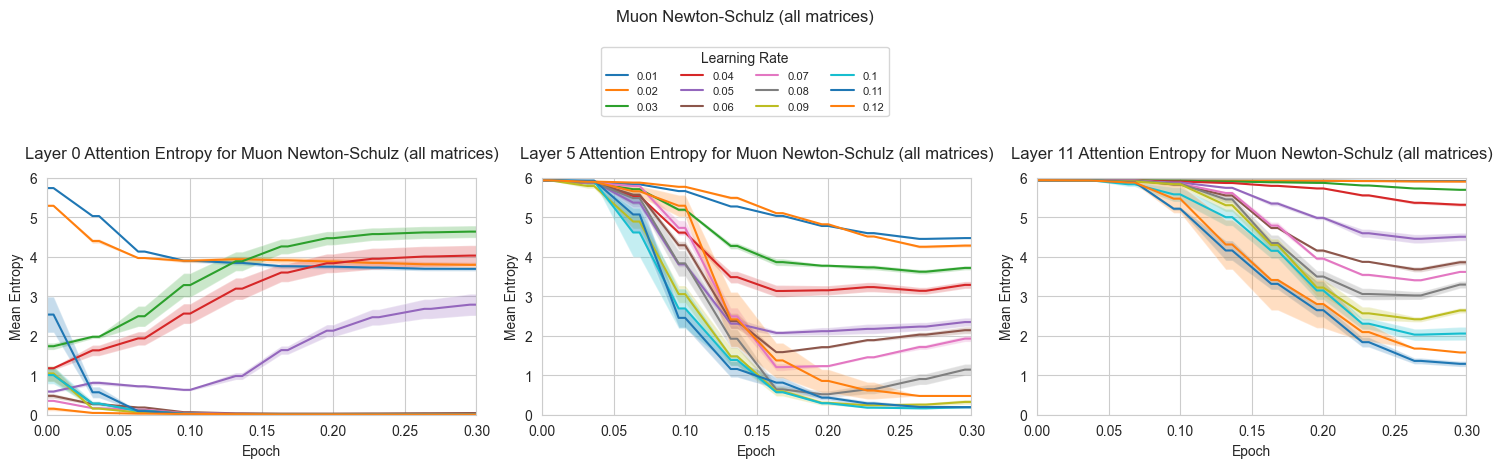

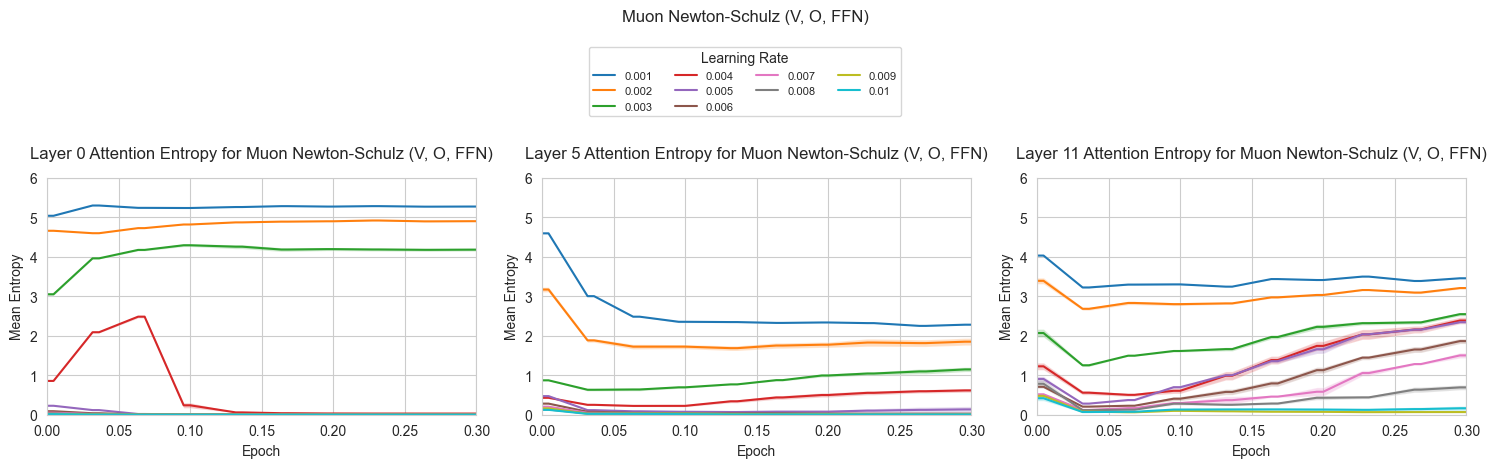

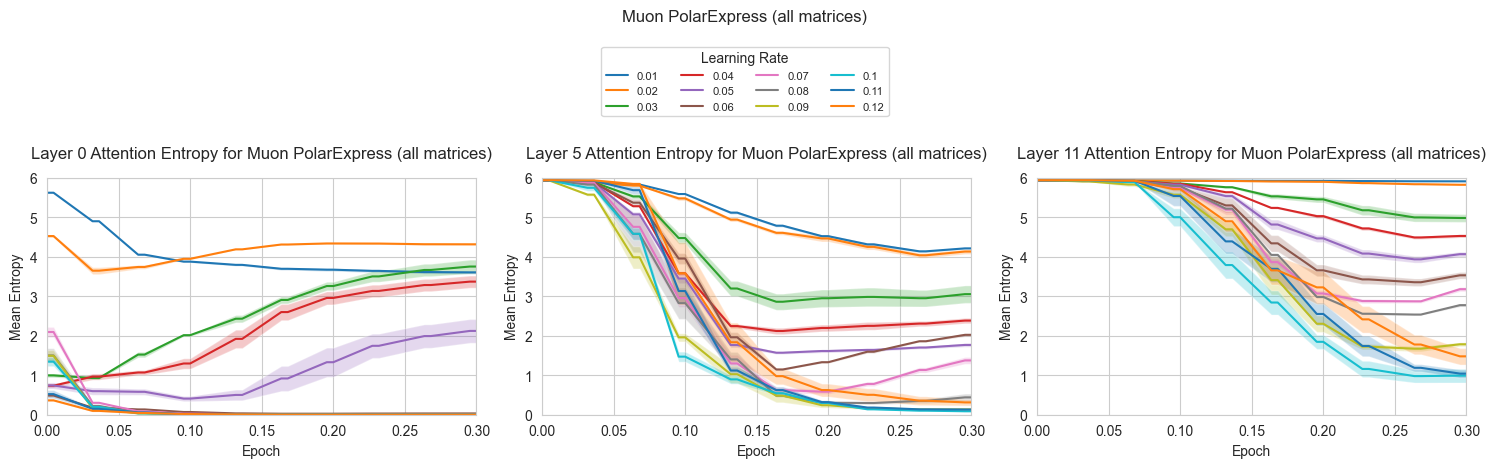

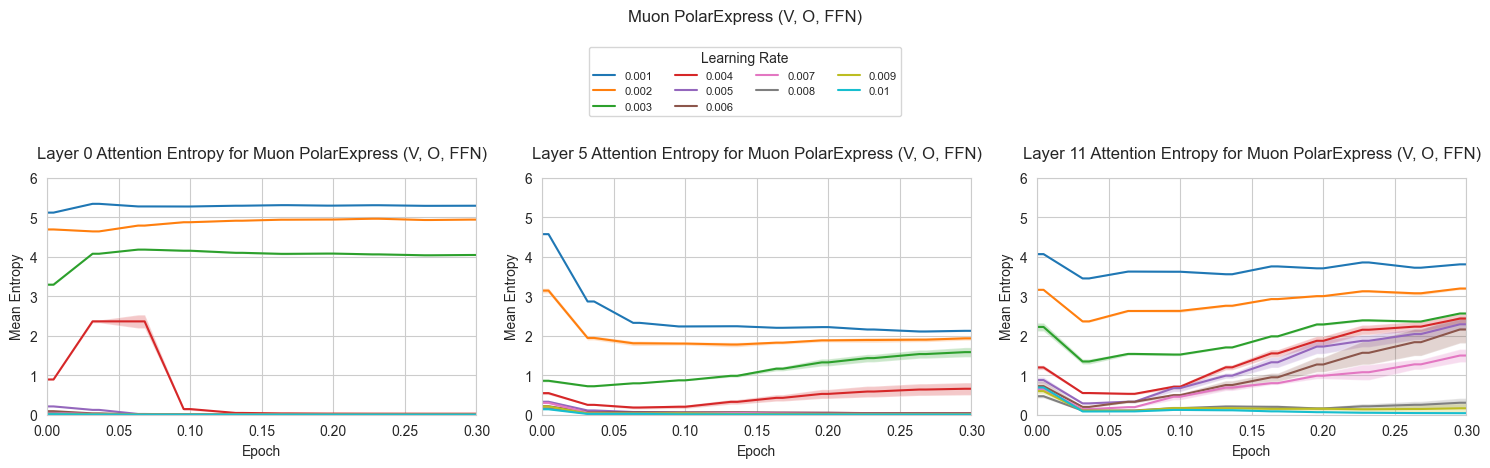

In [29]:
plot_all_layers(layers=(0, 5, 11))

train/loss: found variants ['AdamW', 'Muon NS (V, O, FFN)', 'Muon NS (all matrices)', 'Muon PE (V, O, FFN)', 'Muon PE (all matrices)', 'Muon PE-mod (all matrices)']
val/loss: found variants ['AdamW', 'Muon NS (V, O, FFN)', 'Muon NS (all matrices)', 'Muon PE (V, O, FFN)', 'Muon PE (all matrices)', 'Muon PE-mod (all matrices)']


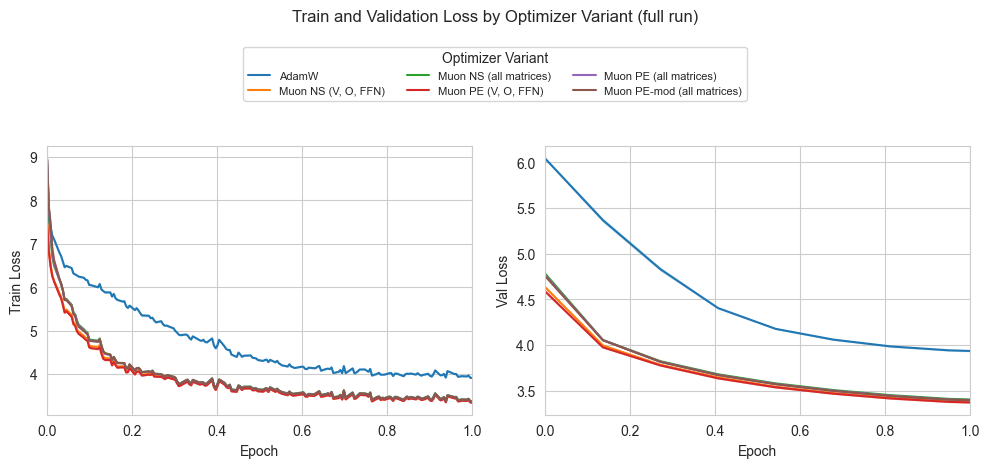

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='Train Loss'>,
        <Axes: xlabel='Epoch', ylabel='Val Loss'>], dtype=object))

In [104]:
plot_all_variants_from_sweeps(epoch_max=1.0)

train/loss: found variants ['AdamW', 'Muon NS (V, O, FFN)', 'Muon NS (all matrices)', 'Muon PE (V, O, FFN)', 'Muon PE (all matrices)', 'Muon PE-mod (all matrices)']
val/loss: found variants ['AdamW', 'Muon NS (V, O, FFN)', 'Muon NS (all matrices)', 'Muon PE (V, O, FFN)', 'Muon PE (all matrices)', 'Muon PE-mod (all matrices)']


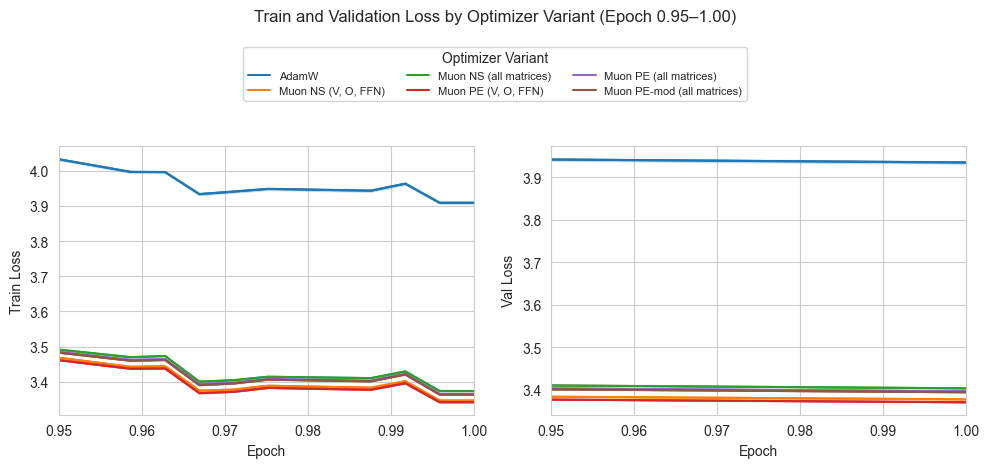

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='Train Loss'>,
        <Axes: xlabel='Epoch', ylabel='Val Loss'>], dtype=object))

In [105]:
plot_all_variants_from_sweeps(epoch_max=1.0, epoch_window=(0.95, 1.0))

train/loss: found variants ['AdamW', 'Muon NS (V, O, FFN)', 'Muon NS (all matrices)', 'Muon PE (V, O, FFN)', 'Muon PE (all matrices)', 'Muon PE-mod (all matrices)']
val/loss: found variants ['AdamW', 'Muon NS (V, O, FFN)', 'Muon NS (all matrices)', 'Muon PE (V, O, FFN)', 'Muon PE (all matrices)', 'Muon PE-mod (all matrices)']


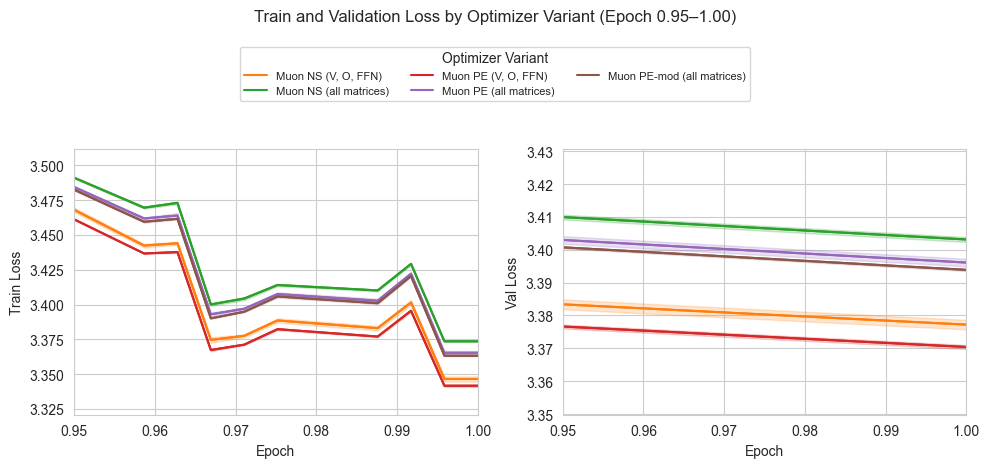

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='Train Loss'>,
        <Axes: xlabel='Epoch', ylabel='Val Loss'>], dtype=object))

In [106]:
plot_all_variants_from_sweeps(epoch_max=1.0,
                              epoch_window=(0.95, 1.0),
                              include_adamw=False)